In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import itertools
import math 
import re
from scipy import stats
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
# Suppressing warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
df_train = pd.read_csv("train.csv") 
df_test = pd.read_csv("test.csv")   
df_train.head()
df_test.head()

,id,emotional_charge_2,groove_efficiency_1,beat_frequency_1,organic_texture_2,composition_label_0,harmonic_scale_1,intensity_index_0,duration_ms_0,album_name_length,...,emotional_resonance_2,time_signature_0,duration_ms_1,harmonic_scale_0,time_signature_2,rhythmic_cohesion_2,emotional_resonance_0,harmonic_scale_2,intensity_index_2,instrumental_density_0
0,25174,0.600480,1.543590,124.008,0.0729,Dr.Q,1.0,0.763,23032.0,4.0,...,0.834,4.0,253987.0,4.0,4.0,0.604,0.2050,0.0,0.720,0.165000
1,38453,NaN,0.722420,129.942,0.0105,Start A Party,11.0,0.801,215466.0,20.0,...,0.216,4.0,267626.0,5.0,4.0,0.881,0.2610,1.0,0.496,0.000000
2,29013,0.461916,0.757962,83.000,0.2700,Sombras - Live,2.0,0.561,252261.0,44.0,...,0.546,4.0,226626.0,0.0,4.0,0.555,0.0555,0.0,0.846,0.002760
3,57463,0.144236,0.923977,183.991,0.1210,Tennis Court,2.0,NaN,198907.0,23.0,...,0.337,4.0,234286.0,0.0,4.0,0.674,0.4040,7.0,0.428,0.000194
4,51264,0.629832,1.473795,201.277,0.0610,La Cumbia Del Lazo,10.0,0.716,158720.0,NaN,...,0.966,4.0,188520.0,8.0,4.0,0.511,0.9620,10.0,0.652,0.000115



## Create Year Month Day cols 

In [5]:
def extract_date_parts(df, date_col='publication_timestamp'):
    # Convert to datetime, coerce errors so invalid/missing are NaT
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    
    # Extract parts
    df['year'] = df[date_col].dt.year.astype('Int64')
    df['month'] = df[date_col].dt.month.astype('Int64')
    df['day'] = df[date_col].dt.day.astype('Int64')
    
    # Fill missing values with mode of each column
    for col in ['year', 'month', 'day']:
        mode_val = df[col].mode(dropna=True)
        if not mode_val.empty:
            df[col] = df[col].fillna(mode_val[0])
    
    # Drop the original timestamp column
    df = df.drop(columns=[date_col])
    
    return df

In [6]:
df_train = extract_date_parts(df_train)
df_test = extract_date_parts(df_test)

# Data Cleaning

In [7]:
df_train.select_dtypes(include=['number']).isna().sum()

id                                0
emotional_charge_2             2442
groove_efficiency_1             180
beat_frequency_1                386
organic_texture_2               383
harmonic_scale_1               3305
intensity_index_0              5971
duration_ms_0                  1289
album_name_length              9594
beat_frequency_0               9731
beat_frequency_2               1766
artist_count                   3261
album_component_count          4363
emotional_charge_1             4014
emotional_charge_0             6104
tonal_mode_2                   1809
key_variety                    5405
performance_authenticity_2     1914
performance_authenticity_0     2105
time_signature_1               1863
duration_ms_2                  1128
instrumental_density_2         4154
organic_texture_0              4337
vocal_presence_2               2534
tonal_mode_1                   4398
vocal_presence_1                865
vocal_presence_0                110
intensity_index_1           

In [8]:
def fill_numerical_nans_with_median(df):
    num_cols = df.select_dtypes(include=['number']).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())
    return
def fill_specific_categoricals_with_mode(df, columns):
    for col in columns:
        if col in df.columns:
            mode_val = df[col].mode(dropna=True)[0]
            df[col] = df[col].fillna(mode_val)
    return

In [9]:
cat_cols = ['weekday_of_release', 'season_of_release', 'lunar_phase','track_identifier','creator_collective','publication_timestamp','composition_label_0','composition_label_1','composition_label_2','']

In [10]:
fill_numerical_nans_with_median(df_train)
fill_numerical_nans_with_median(df_test)
fill_specific_categoricals_with_mode(df_train, cat_cols)
fill_specific_categoricals_with_mode(df_test, cat_cols)

In [11]:
df_train.select_dtypes(include=['object', 'category']).isna().sum()

composition_label_0    0
composition_label_1    0
weekday_of_release     0
season_of_release      0
lunar_phase            0
creator_collective     0
composition_label_2    0
track_identifier       0
dtype: int64

In [12]:
# df_train.select_dtypes(include=['object', 'category'])

## Apply Log Transformation

In [13]:
def apply_log_transform(df, column_list):
    for col in column_list:
        new_col = f"{col}_log"
        df[new_col] = np.log1p(df[col])
    return

In [14]:
log_trans_list = ['album_component_count', 'duration_ms_0', 'duration_ms_1', 'duration_ms_2','groove_efficiency_0','groove_efficiency_1','groove_efficiency_2','organic_immersion_0','organic_immersion_1','organic_immersion_2','duration_consistency','album_name_length','duration_consistency']

In [15]:
apply_log_transform(df_train, log_trans_list )
apply_log_transform(df_test, log_trans_list )

## Binning

In [16]:
def transform_bin(df, column_name):
    # Log transformation
    df[f"{column_name}_log"] = np.log1p(df[column_name])

    # Use qcut to get quantile-based bins
    qcut_bins, bin_edges = pd.qcut(
        df[column_name],
        q=10,
        retbins=True,
        labels=False,
        duplicates='drop'  # In case of duplicate edges
    )

    # Create readable range labels from bin edges
    range_labels = [
        f"{int(left)}–{int(right)}" 
        for left, right in zip(bin_edges[:-1], bin_edges[1:])
    ]

    # Map numeric bin labels to the readable range labels
    df[f"{column_name}_binned"] = qcut_bins.map(dict(enumerate(range_labels)))

    return 
def transform_vocal_features(df, columns=['vocal_presence_0', 'vocal_presence_1', 'vocal_presence_2']):
    for col in columns:
        # Use qcut to get the bins and their edges
        bin_labels, bin_edges = pd.qcut(df[col], q=5, retbins=True, labels=False, duplicates='drop')
        
        # Create labels using the bin edges (range values for each bin)
        range_labels = [
            f"{bin_edges[i]:.2f}–{bin_edges[i+1]:.2f}"
            for i in range(len(bin_edges)-1)
        ]
        
        # Map numeric bin labels to the corresponding range labels
        df[f"{col}_binned"] = bin_labels.map(dict(enumerate(range_labels)))
    
    return
def add_artist_group_flags(df, column_name='artist_count'):
    df['is_duo'] = (df[column_name] == 2).astype(int)
    df['is_small_group'] = ((df[column_name] > 2) & (df[column_name] <= 5)).astype(int)
    df['is_large_group'] = (df[column_name] > 5).astype(int)
    return

In [17]:
def plot_binned_columns(df, column_names, cols_per_row=3, figsize=(18, 5)):
    import matplotlib.pyplot as plt

    total = len(column_names)
    rows = (total + cols_per_row - 1) // cols_per_row
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(figsize[0], figsize[1] * rows))
    axes = axes.flatten()

    for i, col in enumerate(column_names):
        cat_col = f"{col}_binned"
        if cat_col in df.columns:
            counts = df[cat_col].value_counts().sort_index()
            axes[i].bar(counts.index, counts.values, color='#1E90FF')
            axes[i].set_title(cat_col)
            axes[i].set_xlabel('Range')
            axes[i].set_ylabel('Count')
            axes[i].tick_params(axis='x', rotation=45)
        else:
            axes[i].set_visible(False)

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()
def plot_vocal_feature_binning(df, columns=['vocal_presence_0', 'vocal_presence_1', 'vocal_presence_2'], figsize=(15, 10)):
    plt.figure(figsize=figsize)

    # Loop through the list of columns
    for i, col in enumerate(columns, 1):
        # Apply binning into categories (already done inside the transformation function)
        
        # Plot the original data (histogram)
        plt.subplot(len(columns), 2, 2*i-1)
        sns.histplot(df[col], kde=True, color='blue', bins=30)
        plt.title(f'Original {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')

        # Plot the binned data (categorical distribution)
        plt.subplot(len(columns), 2, 2*i)
        sns.countplot(x=df[f'{col}_binned'], palette='Set2')
        plt.title(f'Binned {col}')
        plt.xlabel(f'{col}_binned')
        plt.ylabel('Count')

    plt.tight_layout()
    plt.show()  
def plot_artist_count_violin_and_box(df, column_name='artist_count'):
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))

    sns.violinplot(y=df[column_name], color='lightgreen', ax=axes[0])
    axes[0].set_title('Violin Plot')
    axes[0].set_ylabel(column_name)

    sns.boxplot(y=df[column_name], color='skyblue', ax=axes[1])
    axes[1].set_title('Box Plot')
    axes[1].set_ylabel(column_name)

    plt.suptitle(f"Distribution of '{column_name}'", fontsize=14)
    plt.tight_layout()
    plt.show()    
def plot_artist_group_flags(df):
    import matplotlib.pyplot as plt

    flags = ['is_duo', 'is_small_group', 'is_large_group']
    titles = ['Duo', 'Small Group (3–5)', 'Large Group (6+)']

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for i, flag in enumerate(flags):
        counts = df[flag].value_counts().sort_index()
        axes[i].bar(['No', 'Yes'], counts, color=['lightgray', '#1E90FF'])
        axes[i].set_title(titles[i])
        axes[i].set_ylabel("Count")
        axes[i].set_xlabel("Flag")

    plt.tight_layout()
    plt.show()    

In [18]:
bin_list = ['album_component_count', 'duration_ms_0','duration_ms_1','duration_ms_2','groove_efficiency_0','groove_efficiency_1','groove_efficiency_2','organic_immersion_0','organic_immersion_1','organic_immersion_2','instrumental_density_0','instrumental_density_1','instrumental_density_2',]

In [19]:
for col in bin_list:
    transform_bin(df_train, col)
    
transform_vocal_features(df_train)    
add_artist_group_flags(df_train)
transform_vocal_features(df_test)    
add_artist_group_flags(df_test)

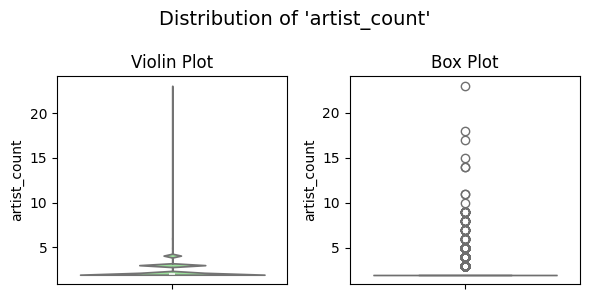

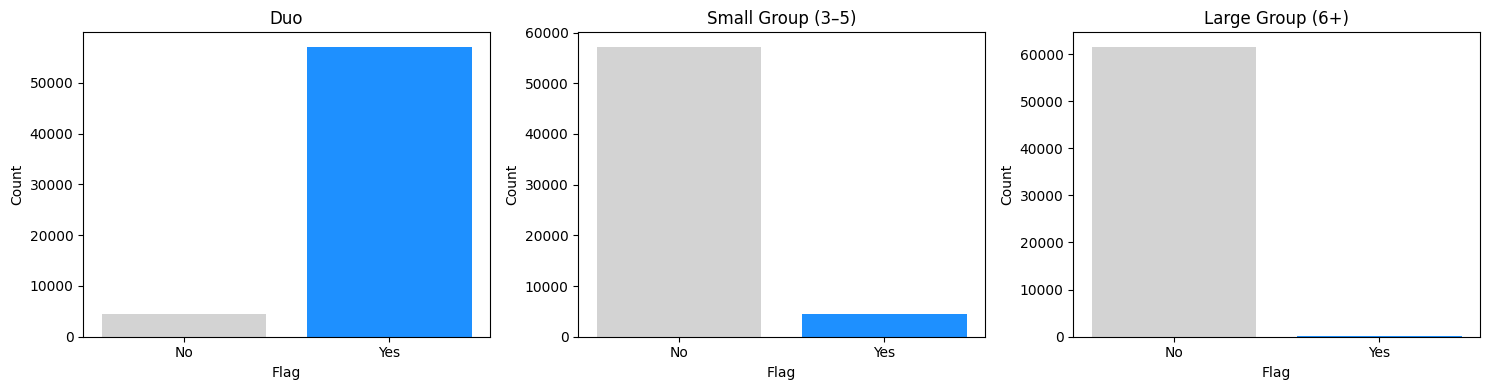

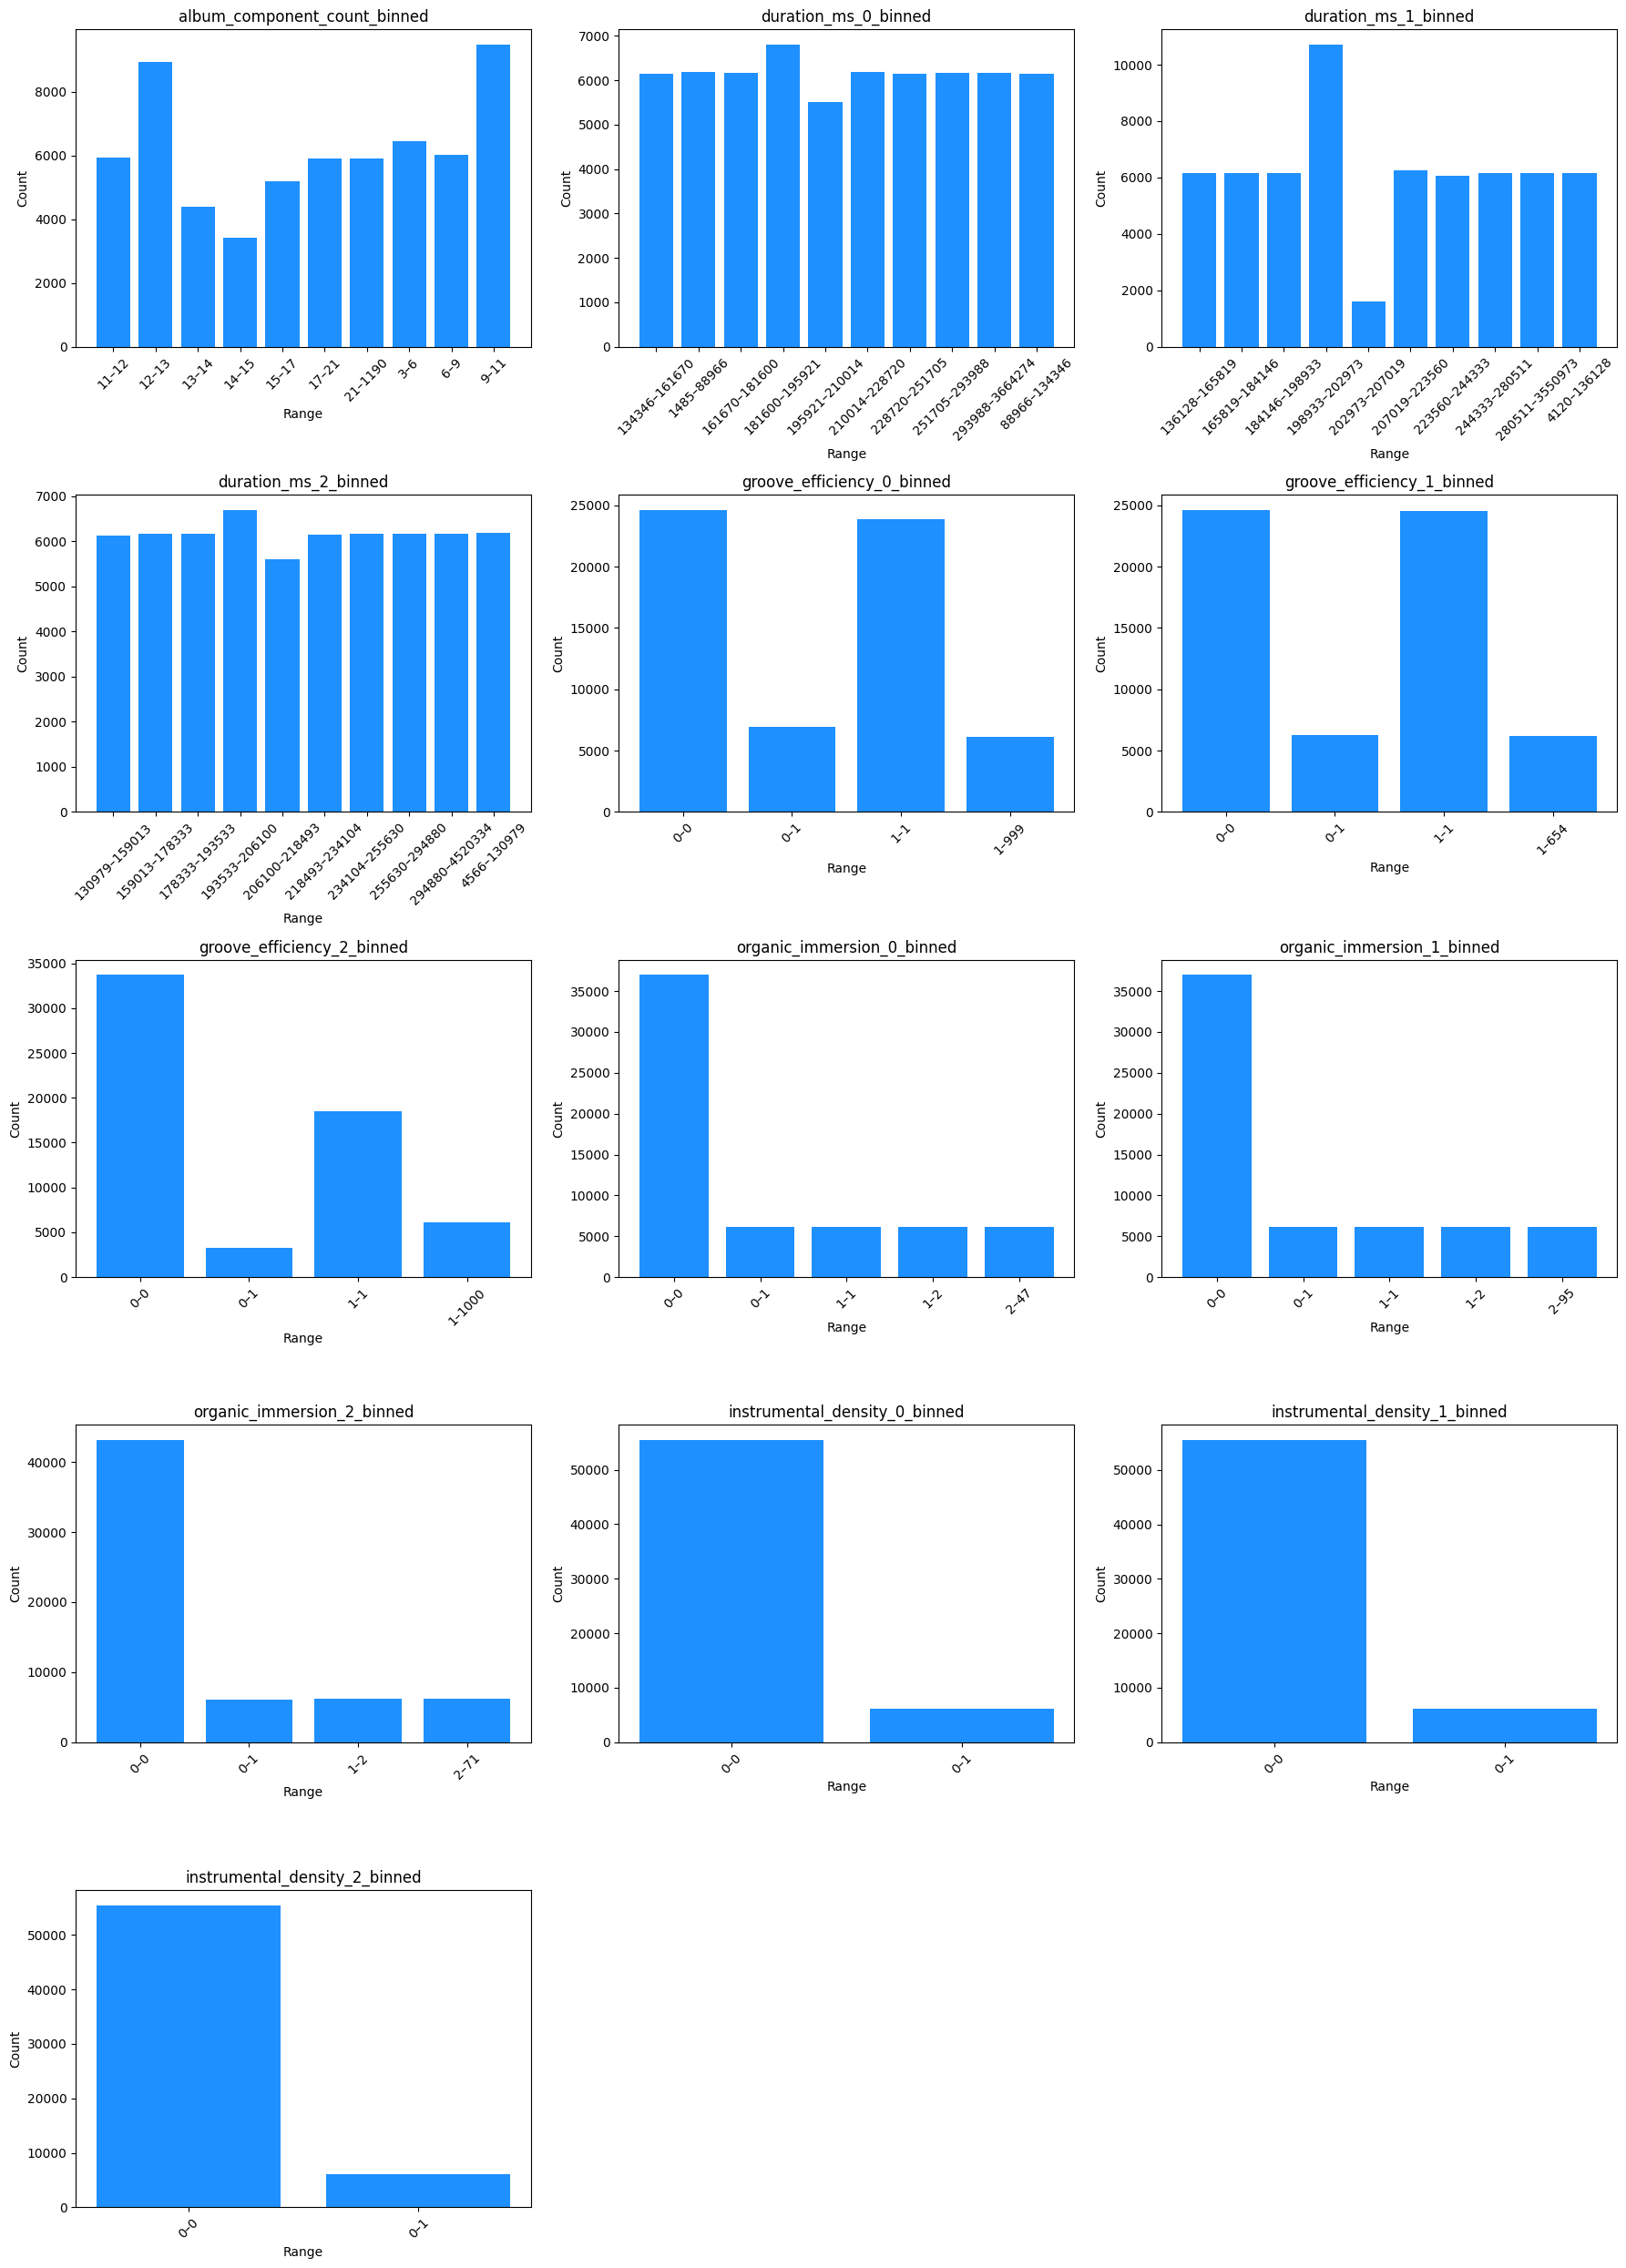

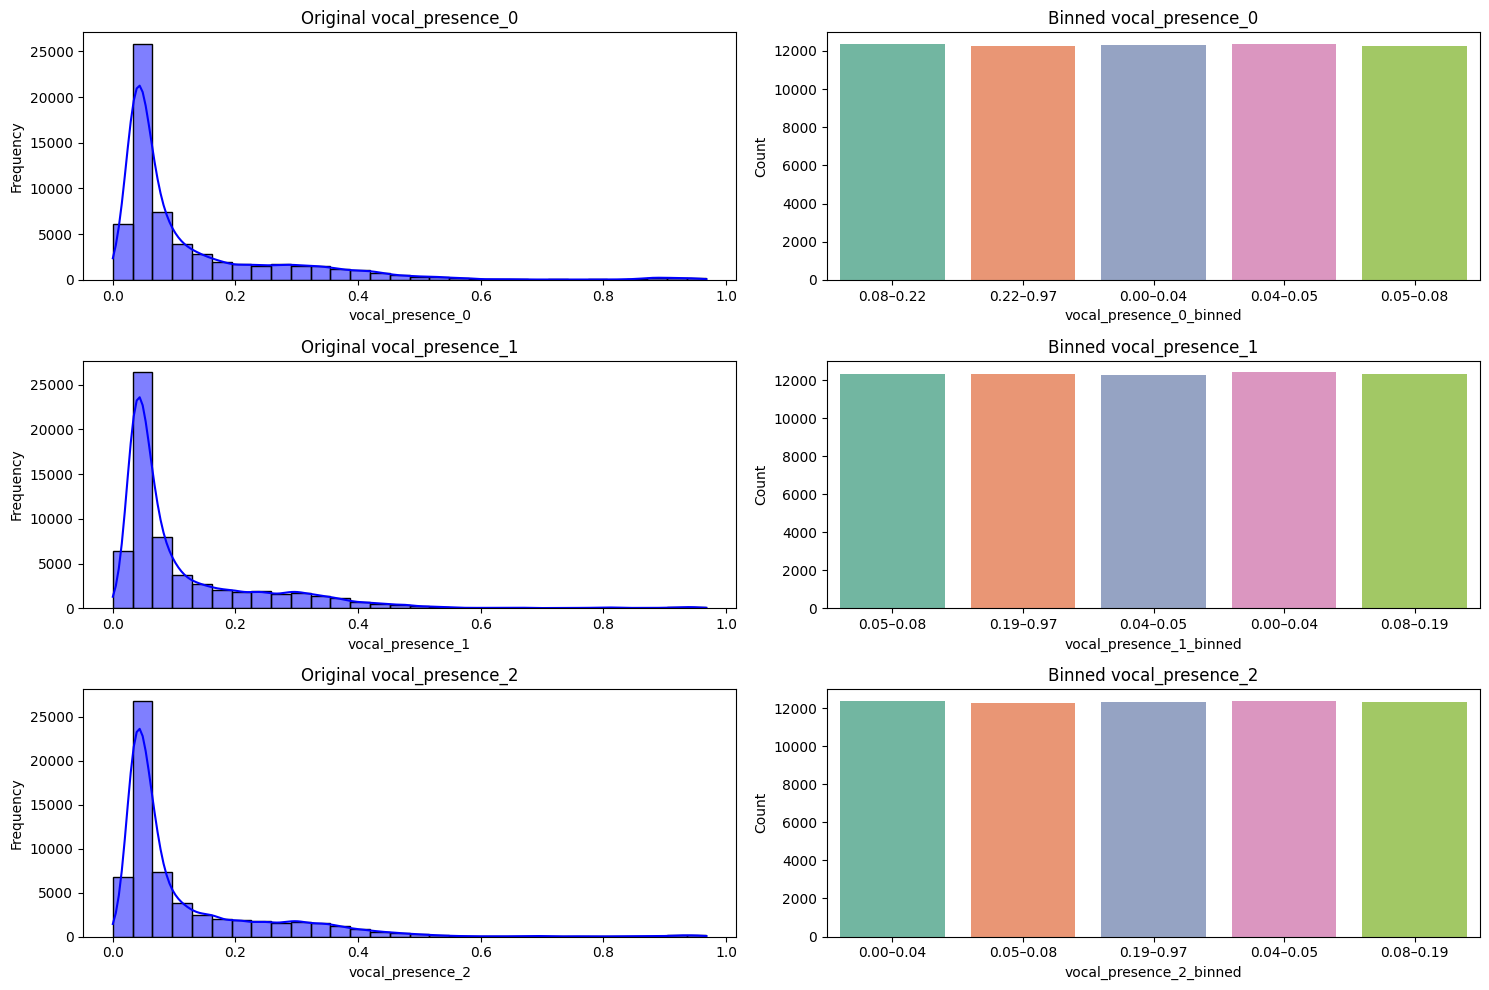

In [20]:
plot_artist_count_violin_and_box(df_train)
plot_artist_group_flags(df_train)
plot_binned_columns(df_train, bin_list)
plot_vocal_feature_binning(df_train, columns=['vocal_presence_0', 'vocal_presence_1', 'vocal_presence_2'])

## Quantile Transformer

In [21]:
def apply_quantile_transform(df, columns, output_suffix='_qt', n_quantiles=1000, output_distribution='normal'):
    transformer = QuantileTransformer(n_quantiles=n_quantiles, output_distribution=output_distribution, random_state=0)
    
    for col in columns:
        transformed = transformer.fit_transform(df[[col]])
        df[f"{col}{output_suffix}"] = transformed
    
    return
def remove_original_columns(df, columns_to_remove):
    df.drop(columns=columns_to_remove, inplace=True)
    return

In [22]:
quantile_trans_list = ['album_component_count', 'duration_ms_0', 'duration_ms_1', 'duration_ms_2','groove_efficiency_0','groove_efficiency_1','groove_efficiency_2','organic_immersion_0','organic_immersion_1','organic_immersion_2','duration_consistency','album_name_length','artist_count','instrumental_density_0','instrumental_density_1','instrumental_density_2','vocal_presence_0','vocal_presence_1','vocal_presence_2','artist_count']

columns_to_remove = [
    'album_component_count', 'duration_ms_0', 'duration_ms_1', 'duration_ms_2',
    'groove_efficiency_0', 'groove_efficiency_1', 'groove_efficiency_2',
    'organic_immersion_0', 'organic_immersion_1', 'organic_immersion_2',
    'instrumental_density_0', 'instrumental_density_1', 'instrumental_density_2',
    'vocal_presence_0', 'vocal_presence_1', 'vocal_presence_2','duration_consistency','album_name_length','artist_count'
]

In [23]:
apply_quantile_transform(df_train, quantile_trans_list)
remove_original_columns(df_train, columns_to_remove)
apply_quantile_transform(df_test, quantile_trans_list)
remove_original_columns(df_test, columns_to_remove)

# Model Training

In [24]:
df_train.shape

(61609, 98)

In [25]:
X = df_train.drop('target', axis=1)
y = df_train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

## Model Training

In [ ]:
import optuna
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Identify numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing: RobustScaler for numeric, OrdinalEncoder for categoricals
scaler = RobustScaler()
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

transformer = make_column_transformer(
    (scaler, numeric_cols),
    (encoder, categorical_cols),
    remainder='drop'  # Drop anything else
)

# Hyperparameter tuning function using Optuna
def tune(trial):
    model = XGBRegressor(
        n_estimators=trial.suggest_int("n_estimators", 50, 500),
        max_depth=trial.suggest_int("max_depth", 2, 12),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        subsample=trial.suggest_float("subsample", 0.6, 0.95),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        gamma=trial.suggest_float("gamma", 0.1, 7.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.1, 15.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.1, 15.0),
        scale_pos_weight=trial.suggest_float("scale_pos_weight", 0.5, 5.0),
        max_delta_step=trial.suggest_int("max_delta_step", 0, 10),
        random_state=42,
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        verbosity=0
    )

    composed_model = make_pipeline(transformer, model)
    scores = cross_val_score(composed_model, X_train, y_train, scoring="neg_mean_absolute_error", cv=3)
    return abs(scores.mean())

# Run Optuna optimization
optuna_study = optuna.create_study(direction="minimize")
optuna_study.optimize(tune, n_trials=50)

# Retrieve best parameters
optimal = optuna_study.best_params
optimal['random_state'] = 42
optimal['verbosity'] = 0

# Final pipeline
regressor = XGBRegressor(**optimal)
final_model = make_pipeline(transformer, regressor)
final_model.fit(X_train, y_train)
y_pred_xgb = final_model.predict(X_test)

# Metric function
def pct_in_range(true_vals, predictions, margin):
    return 100 * np.mean(np.abs(true_vals - predictions) <= margin)

# Evaluation
mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)

print("\nModel Evaluation:")
print("MAE :", round(mae, 3))
print("MSE :", round(mse, 3))
print("RMSE:", round(rmse, 3))
print("Within ±5 units :", f"{pct_in_range(y_test, y_pred_xgb, 5):.2f}%")
print("Within ±10 units:", f"{pct_in_range(y_test, y_pred_xgb, 10):.2f}%")


[I 2025-06-01 12:29:32,299] A new study created in memory with name: no-name-7d9607d3-3c74-4f16-acf1-f6c486a037c2
[I 2025-06-01 12:29:49,782] Trial 0 finished with value: 14.645347118706631 and parameters: {'n_estimators': 346, 'max_depth': 5, 'learning_rate': 0.16623357854560888, 'min_child_weight': 8, 'subsample': 0.8949128560358165, 'colsample_bytree': 0.7713309978304697, 'gamma': 3.4766719001754365, 'reg_alpha': 0.5283598556839579, 'reg_lambda': 12.417588262103717, 'scale_pos_weight': 2.0890254580036967, 'max_delta_step': 1}. Best is trial 0 with value: 14.645347118706631.
[I 2025-06-01 12:30:01,202] Trial 1 finished with value: 12.854929047471693 and parameters: {'n_estimators': 343, 'max_depth': 2, 'learning_rate': 0.13781689777562792, 'min_child_weight': 5, 'subsample': 0.9378533413444514, 'colsample_bytree': 0.8638145319141215, 'gamma': 5.032237585860636, 'reg_alpha': 11.858182637492472, 'reg_lambda': 6.998356097109239, 'scale_pos_weight': 4.1077160354758675, 'max_delta_step': 

KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor, VotingRegressor

# Create ExtraTreesRegressor
etr_model = ExtraTreesRegressor(
    n_estimators=100,  # you can tune this if needed
    random_state=42
)

# Create the best XGBRegressor from Optuna results
xgb_model = XGBRegressor(**optimal)

# Voting Regressor (ensemble)
ensemble_model = VotingRegressor(
    estimators=[
        ('xgb', xgb_model),
        ('etr', etr_model)
    ]
)

# Final ensemble pipeline
ensemble_pipeline = make_pipeline(transformer, ensemble_model)

# Fit and predict
ensemble_pipeline.fit(X_train, y_train)
y_pred_ensemble = ensemble_pipeline.predict(X_test)

# Evaluation
mae_ens = mean_absolute_error(y_test, y_pred_ensemble)
rmse_ens = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))

print("\nEnsemble Evaluation (XGB + ExtraTrees):")
print("MAE :", round(mae_ens, 3))
print("RMSE:", round(rmse_ens, 3))
print("Within ±5 units :", f"{pct_in_range(y_test, y_pred_ensemble, 5):.2f}%")
print("Within ±10 units:", f"{pct_in_range(y_test, y_pred_ensemble, 10):.2f}%")


In [ ]:
from lightgbm import LGBMRegressor

# Define tuning function for LGBM
def tune_lgbm(trial):
    model = LGBMRegressor(
        n_estimators=trial.suggest_int("n_estimators", 50, 500),
        max_depth=trial.suggest_int("max_depth", 2, 12),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        num_leaves=trial.suggest_int("num_leaves", 20, 100),
        min_child_samples=trial.suggest_int("min_child_samples", 5, 50),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 10.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 10.0),
        random_state=42
    )

    composed_model = make_pipeline(transformer, model)
    scores = cross_val_score(composed_model, X_train, y_train, scoring="neg_mean_absolute_error", cv=3)
    return abs(scores.mean())

# Run Optuna for LGBM
optuna_lgbm_study = optuna.create_study(direction="minimize")
optuna_lgbm_study.optimize(tune_lgbm, n_trials=50)

# Best params
lgbm_best = optuna_lgbm_study.best_params
lgbm_best['random_state'] = 42

# Final LGBM pipeline
lgbm_model = LGBMRegressor(**lgbm_best)
lgbm_pipeline = make_pipeline(transformer, lgbm_model)

# Fit and predict
lgbm_pipeline.fit(X_train, y_train)
y_pred_lgbm = lgbm_pipeline.predict(X_test)

# Evaluation
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))

print("\nLightGBM Model Evaluation:")
print("MAE :", round(mae_lgbm, 3))
print("RMSE:", round(rmse_lgbm, 3))
print("Within ±5 units :", f"{pct_in_range(y_test, y_pred_lgbm, 5):.2f}%")
print("Within ±10 units:", f"{pct_in_range(y_test, y_pred_lgbm, 10):.2f}%")
